In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
sns.set()
from sklearn import metrics, preprocessing, feature_extraction, dummy, neighbors,linear_model,svm,model_selection,feature_selection
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
print(os.getcwd())

C:\Users\arsal\opencv\Scripts\OFSTED\notebooks


In [3]:
os.chdir('../data/processed')

In [4]:
combined_ofsted_df = pd.read_csv(os.getcwd() + '/ComponentOneData.csv')

# Basic Machine Learning Tasks

Remove all the schools with a Rating of “Unknown”. Combine all the ratings that aren’t “Outstanding” or “Good” into a single rating of “Not Good”.

In [5]:
combined_ofsted_df = combined_ofsted_df.loc[combined_ofsted_df['Rating'] != 'Unknown']
combined_ofsted_df.loc[(combined_ofsted_df['Rating'].str.startswith('Requires Improvement') == True) |
                       (combined_ofsted_df['Rating'].str.startswith('Inadequate') == True) |
                       (combined_ofsted_df['Rating'].str.startswith('Satisfactory') == True), 'Rating'] = 'Not Good'
combined_ofsted_df['Rating'].unique()

array(['Good', 'Outstanding', 'Not Good'], dtype=object)

Baseline accuracy

In [6]:
combined_ofsted_df['Rating'].value_counts(normalize=True)

## This tells us that in the data, 59.3% of the examples are Good Rating. 
## We can get this level of accuracy by just always predicting "Good"
## Other qualities are going to be difficult to predict, especially Outstanding which barely appears.

Good           0.593021
Not Good       0.225082
Outstanding    0.181897
Name: Rating, dtype: float64

In [7]:
combined_ofsted_df['Rating'].value_counts()

## Only 834 examples with Outstanding Rating

Good           2719
Not Good       1032
Outstanding     834
Name: Rating, dtype: int64

In [8]:
len(combined_ofsted_df['Rating'][combined_ofsted_df['Rating']=='Good'])/(len(combined_ofsted_df))

## Any model that gets less than 59.3% accuracy is worse than guessing

0.593020719738277

In [9]:
selected_features = combined_ofsted_df.loc[:,(combined_ofsted_df.dtypes == float)]

In [10]:
X = selected_features.values
y = combined_ofsted_df['Rating'].values.reshape(-1,1)

**Baseline Modelling**

In [11]:
names = ['KNN','Logistic','Linear SVM','Non-Linear SVM','MultinomialNB','GaussianNB','BernoulliNB']
models = [neighbors.KNeighborsClassifier(n_neighbors = 7, weights = 'distance', metric = 'minkowski', p=2), 
          linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=9999),
          svm.LinearSVC(max_iter=9999),
          svm.SVC(kernel='rbf', gamma='scale', max_iter=9999),
         MultinomialNB(),
         GaussianNB(),
         BernoulliNB()]
accuracies = []
cross_validator = model_selection.KFold(n_splits=5, shuffle=True, random_state=200)
for model in models:
    scores = model_selection.cross_val_score(estimator=model, X=X, y=y, cv=cross_validator)
    accuracies.append(np.mean(scores))
results = pd.DataFrame({'model':names, 'baseline':accuracies})
results.sort_values(by='baseline', ascending=False)[['model','baseline']]

## Logistic Regression performed a little better than the baseline
## Non-Linear SVM is about the same as the baseline
## Rest all are worse than the baseline
## In different types of Naive Bayes, MultinomialNB is worst here. 

,model,baseline
1,Logistic,0.603272
3,Non-Linear SVM,0.593675
6,BernoulliNB,0.589095
0,KNN,0.568593
5,GaussianNB,0.564449
2,Linear SVM,0.337623
4,MultinomialNB,0.296183


confusion matrix

In [12]:
clf = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=9999)
cross_validator = model_selection.KFold(n_splits=5, shuffle=True, random_state=200)
scores = model_selection.cross_val_score(estimator=clf, X=X, y=y, cv=cross_validator)
y_pred = model_selection.cross_val_predict(estimator=clf, X=X, y=y, cv=cross_validator)
accuracy_score(y, y_pred)

0.6032715376226827

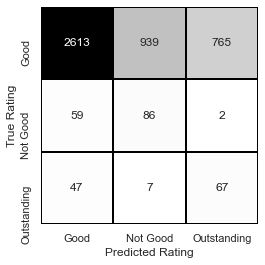

In [13]:
# metrics
cm = metrics.confusion_matrix(y_pred, y)

# heatmap
fig, ax = plt.subplots(figsize = (8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Greys",square=True,linewidth=0.7,linecolor='black', ax=ax, cbar=False)


# ticks
ticks_labels = np.unique(y).tolist()
plt.xticks(np.arange(len(ticks_labels)) + .5, labels=ticks_labels)
plt.yticks(np.arange(len(ticks_labels)) + .5, labels=ticks_labels)

# axis labels
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')

plt.show()

# Feature Engineering


5. You may have noticed that some of the classifiers do not work with the Progress 8 features because they contain negative values. Propose and implement a simple solution to this problem.

In [14]:
prog8 = []
for col in combined_ofsted_df.columns: 
    if '8' in col:
        prog8.append(col)        

In [15]:
##The progress 8 fatures also have non numeric values so, first I'm going convert these value wih mean 
##and than going to check the element is less than zero, if yes then assign zero in this element.

prog8Features = combined_ofsted_df[prog8]
for col in prog8Features.columns:
    mean = round(prog8Features[col].transform(pd.to_numeric, errors='coerce').mean(),1)
    dictMean = {'NE': mean, 'SUPP': mean, 'NP': mean, 'LOWCOV': mean,'SP': mean}
    prog8Features[col] = prog8Features[col].astype(object).replace(dictMean)
    prog8Features[col] = prog8Features[col].astype(float)
    if (prog8Features[col].values < 0).any():
        prog8Features[col].loc[prog8Features[col] < 0] = 0

Encoding

1. For Random encoding, we can use LabelEncoder

2. For Ranking encoder, we could use OrdinalEncoder

I'm going to use OrdinalEncoder so, I can set Ranking as I want.

In [16]:
ranks = [['Girls', 'Boys','Mixed']]
oe = preprocessing.OrdinalEncoder(categories = ranks)
combined_ofsted_df['GENDER_OrdEnc']  = oe.fit_transform(combined_ofsted_df['GENDER'].values.reshape(-1,1))
combined_ofsted_df['GENDER_OrdEnc'].unique()

array([2., 0., 1.])

Combining these values will be helpful to assign one category. It will make the hierarchy of different religions.

In [17]:
combined_ofsted_df.loc[(combined_ofsted_df['RELCHAR'].str.startswith('Islam') == True) |
                       (combined_ofsted_df['RELCHAR'].str.startswith('Sunni Deobandi') == True) |
                       (combined_ofsted_df['RELCHAR'].str.startswith('Muslim') == True), 'RELCHAR'] = 'Muslim'

combined_ofsted_df.loc[(combined_ofsted_df['RELCHAR'].str.startswith('Roman Catholic') == True) |
                       (combined_ofsted_df['RELCHAR'].str.startswith('Church of England') == True) |
                       (combined_ofsted_df['RELCHAR'].str.startswith('Christian/Evangelical') == True) | 
                       (combined_ofsted_df['RELCHAR'].str.startswith('Church of England/Roman Catholic') == True) | 
                       (combined_ofsted_df['RELCHAR'].str.startswith('Roman Catholic/Church of England') == True) | 
                       (combined_ofsted_df['RELCHAR'].str.startswith('Anglican/Christian') == True) |
                       (combined_ofsted_df['RELCHAR'].str.startswith('Church of England/Christian') == True) |
                       (combined_ofsted_df['RELCHAR'].str.startswith('Church of England/Methodist') == True) |
                       (combined_ofsted_df['RELCHAR'].str.startswith('Catholic') == True) |
                       (combined_ofsted_df['RELCHAR'].str.startswith('Quaker') == True) |
                       (combined_ofsted_df['RELCHAR'].str.startswith('Inter- / non- denominational') == True),'RELCHAR'] = 'Christian'

combined_ofsted_df.loc[(combined_ofsted_df['RELCHAR'].str.startswith('Charadi Jewish') == True) |
                       (combined_ofsted_df['RELCHAR'].str.startswith('Orthodox Jewish') == True) |
                       (combined_ofsted_df['RELCHAR'].str.startswith('Greek Orthodox') == True), 'RELCHAR'] = 'Jewish'

In [18]:
le = preprocessing.LabelEncoder()
combined_ofsted_df['RELCHAR_LabEnc'] = le.fit_transform(combined_ofsted_df['RELCHAR'].values.reshape(-1,1))

Accuracy with new features

In [19]:
frames = [selected_features, combined_ofsted_df[['GENDER_OrdEnc','RELCHAR_LabEnc']],prog8Features]
selectedFeatures = pd.concat(frames, axis=1)

In [20]:
X = selected_features.values
y = combined_ofsted_df['Rating'].values.reshape(-1,1)

In [21]:
accuracies = []
for model in models:
    scores = model_selection.cross_val_score(estimator=model, X=X, y=y, cv=cross_validator)
    accuracies.append(np.mean(scores))
results['new_features'] = accuracies
results.sort_values(by='new_features', ascending=False)[['model','new_features','baseline']]

,model,new_features,baseline
1,Logistic,0.603272,0.603272
3,Non-Linear SVM,0.593675,0.593675
6,BernoulliNB,0.589095,0.589095
0,KNN,0.568593,0.568593
5,GaussianNB,0.564449,0.564449
2,Linear SVM,0.440785,0.337623
4,MultinomialNB,0.296183,0.296183


The remaining features are a mix of numeric and non-numeric values.

In [22]:
remaining_cols = combined_ofsted_df.columns[(combined_ofsted_df.columns.isin(selected_features)) == False]
remaining_cols = combined_ofsted_df[remaining_cols].drop(columns=['URN','LA','GENDER','RELCHAR','Rating'])

**General abbreviations:**		
**NEW:**	New institution	
**NE:**	No entries: the school or college did not enter any pupils or students for the qualifications covered by the measure	
**NA:**	Not applicable: figures are either not available for the year in question, or the data field is not applicable to this school or college	
**SUPP**	Suppressed: In certain circumstances we will suppress an establishment's data. This is usually when there are 5 or fewer pupils or students covered by the measure (10 in the case of destination measures)	
**NP:**	Not published: for example, we do not publish Progress 8 data for independent schools and independent special schools, or breakdowns by disadvantaged and other pupils for independent schools, independent special schools and non-maintained special schools	
**LOWCOV:**	Low coverage: shown for the ‘value added’ measure and coverage indicator where schools have less than 50% of pupils included in calculation of the measure	
**SP:**	Small percentage: the number is between 0% and 0.5%	
**RE:**	Redacted: of a reliable estimate and therefore don’t provide a fair measure of performance. For transparency, we publish the headline information for these providers separately in the national achievement rates tables	
		


In [23]:
## imputing mean with non-numeric values. So, it will be usable by classifiers    
for col in remaining_cols.columns:
    mean = round(remaining_cols[col].transform(pd.to_numeric, errors='coerce').mean(),1)
    dictMean = {'NE': mean, 'SUPP': mean, 'NP': mean, 'LOWCOV': mean,'SP': mean}
    remaining_cols[col] = remaining_cols[col].astype(object).replace(dictMean)
    remaining_cols[col] = remaining_cols[col].astype(float)

Accuracy of the classifiers with these new features.

In [24]:
frames = [selected_features, remaining_cols]
selected_features = pd.concat(frames, axis=1)

In [25]:
X = selected_features.values
y = combined_ofsted_df['Rating'].values.reshape(-1,1)

In [26]:
accuracies = []
for model in models:
    scores = model_selection.cross_val_score(estimator=model, X=X, y=y, cv=cross_validator)
    accuracies.append(np.mean(scores))
results['all_features'] = accuracies
results.sort_values(by='all_features', ascending=False)[['model','all_features','new_features','baseline']]

,model,all_features,new_features,baseline
1,Logistic,0.643621,0.603272,0.603272
6,BernoulliNB,0.596728,0.589095,0.589095
3,Non-Linear SVM,0.595202,0.593675,0.593675
0,KNN,0.584951,0.568593,0.568593
5,GaussianNB,0.579716,0.564449,0.564449
2,Linear SVM,0.476990,0.440785,0.337623
4,MultinomialNB,NaN,0.296183,0.296183


Standardisation and normalisation to improve the accuracy of the classifiers.

In [27]:
min_max_scaler = preprocessing.MinMaxScaler()
X_Min_Max = min_max_scaler.fit_transform(X)

In [28]:
accuracies = []
for model in models:
    scores = model_selection.cross_val_score(estimator=model, X=X_Min_Max, y=y, cv=cross_validator)
    accuracies.append(np.mean(scores))
results['all_features_Min_Max'] = accuracies
results.sort_values(by='all_features_Min_Max', ascending=False)[['model','all_features_Min_Max','all_features','new_features','baseline']]

,model,all_features_Min_Max,all_features,new_features,baseline
3,Non-Linear SVM,0.651690,0.595202,0.593675,0.593675
1,Logistic,0.647110,0.643621,0.603272,0.603272
2,Linear SVM,0.642312,0.476990,0.440785,0.337623
0,KNN,0.615703,0.584951,0.568593,0.568593
4,MultinomialNB,0.596074,NaN,0.296183,0.296183
6,BernoulliNB,0.586478,0.596728,0.589095,0.589095
5,GaussianNB,0.579935,0.579716,0.564449,0.564449


In [29]:
scaler = preprocessing.StandardScaler()
X_Scaled = scaler.fit_transform(X)

In [30]:
accuracies = []
for model in models:
    scores = model_selection.cross_val_score(estimator=model, X=X_Scaled, y=y, cv=cross_validator)
    accuracies.append(np.mean(scores))
results['all_features_Scaled'] = accuracies
results.sort_values(by='all_features_Scaled', ascending=False)[['model','all_features_Scaled','all_features_Min_Max','all_features','new_features','baseline']]

## MultinomialNB is suitable for discrete features. I'm going to use X_Min_Max normalisation.

,model,all_features_Scaled,all_features_Min_Max,all_features,new_features,baseline
3,Non-Linear SVM,0.647983,0.651690,0.595202,0.593675,0.593675
2,Linear SVM,0.644275,0.642312,0.476990,0.440785,0.337623
1,Logistic,0.641221,0.647110,0.643621,0.603272,0.603272
0,KNN,0.606543,0.615703,0.584951,0.568593,0.568593
5,GaussianNB,0.579935,0.579935,0.579716,0.564449,0.564449
6,BernoulliNB,0.533261,0.586478,0.596728,0.589095,0.589095
4,MultinomialNB,NaN,0.596074,NaN,0.296183,0.296183


In [31]:
## Rounding (By default will round to nearest integer and Specify number of decimal places)
for col in selected_features.columns:
    selected_features[col] = selected_features[col].apply(lambda x: round(x))

In [32]:
mi_scores = feature_selection.mutual_info_classif(X_Min_Max, y)
features = pd.DataFrame({'feature':selected_features.columns,'mi':mi_scores})
features.sort_values(by='mi', ascending=False).head(10)

,feature,mi
15,P8CILOW,0.164386
14,P8MEA,0.154288
13,ATT8SCR,0.148419
17,EBACCAPS,0.148104
16,P8CIUPP,0.139006
23,PT5EM_94,0.129405
19,PTL2BASICS_95,0.122870
18,PTL2BASICS_94,0.122320
22,PTEBACC_95,0.115283
21,PTEBACC_94,0.099076


In [33]:
top_features = features.sort_values(by='mi', ascending=False)['feature'].head(20).tolist()

In [34]:
selected_features[top_features].describe()
## Now most of the top feature values are already in [0,1,2]. 
##However, We can work on these columns [ATT8SCR,PPERSABS10,PERCTOT,PSENELSE]

,P8CILOW,P8MEA,ATT8SCR,EBACCAPS,P8CIUPP,PT5EM_94,PTL2BASICS_95,PTL2BASICS_94,PTEBACC_95,PTEBACC_94,P8_BANDING,PTEBACC_E_PTQ_EE,PPERSABS10,NOT_SUSTAINEDPER,OVERALL_DESTPER,PNUMFSM,PERCTOT,NOT_SUSTAINEDPER_DIS,OVERALL_DESTPER_DIS,PSENELSE
count,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000,4585.0,4585.0,4585.000000
mean,-0.308397,-0.141330,42.856270,3.754198,0.010251,0.692257,0.147437,0.820720,0.014613,0.043839,3.150709,0.180153,17.122792,0.003708,0.993021,0.032061,6.874809,0.0,1.0,25.133697
std,0.749335,0.644215,11.918538,1.181775,0.540772,0.461610,0.354580,0.383629,0.120010,0.204758,1.001837,0.384356,9.932976,0.060785,0.083259,0.176182,3.529857,0.0,0.0,38.851310
min,-5.000000,-4.000000,0.000000,0.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,1.0,0.000000
25%,0.000000,0.000000,42.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,13.000000,0.000000,1.000000,0.000000,5.000000,0.0,1.0,1.000000
50%,0.000000,0.000000,45.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,15.000000,0.000000,1.000000,0.000000,7.000000,0.0,1.0,2.000000
75%,0.000000,0.000000,47.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,18.000000,0.000000,1.000000,0.000000,7.000000,0.0,1.0,22.000000
max,1.000000,2.000000,83.000000,8.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,88.000000,1.000000,1.000000,1.000000,50.000000,0.0,1.0,100.000000


In [35]:
## First I'm going to make copy of selected_features
selected_features = selected_features.copy()

<AxesSubplot:xlabel='PERCTOT', ylabel='Density'>

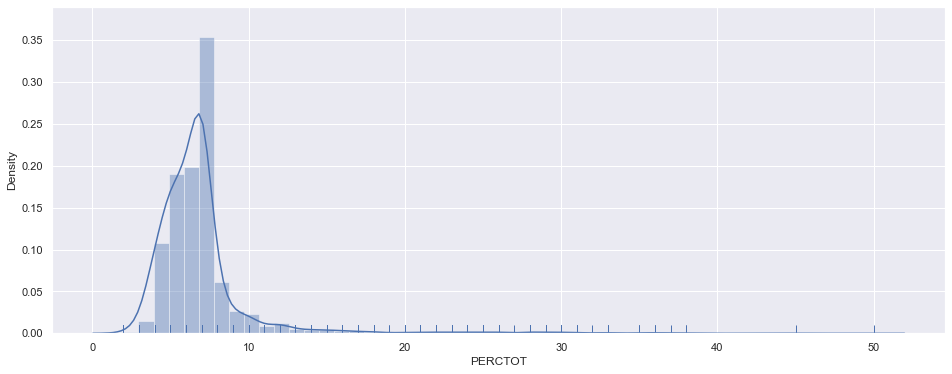

In [36]:
## 1. PERCTOT
fig, ax = plt.subplots(figsize = (16,6))
sns.distplot(selected_features['PERCTOT'], rug=True, ax=ax)
## We can apply Log Transformation as it is right skewed

In [37]:
selected_features_copy['PERCTOT'] = selected_features_copy['PERCTOT'].apply(np.log10)

NameError: name 'selected_features_copy' is not defined

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))
sns.distplot(selected_features_copy['PERCTOT'], rug=True, ax=ax)
## Now it's better than before 

In [ ]:
## 2. ATT8SCR
fig, ax = plt.subplots(figsize = (16,6))
sns.distplot(selected_features_copy['ATT8SCR'], rug=True, ax=ax)
## we can use binning in this column

In [ ]:
selected_features_copy['ATT8SCR'] = pd.cut(selected_features_copy['ATT8SCR'], bins=8,labels=range(1,9))

In [ ]:
selected_features_copy['ATT8SCR'].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))
sns.distplot(selected_features_copy['ATT8SCR'], rug=True, ax=ax)

In [ ]:
## 3. PSENELSE
fig, ax = plt.subplots(figsize = (16,6))
sns.distplot(selected_features_copy['PSENELSE'], rug=True, ax=ax)
## We can binning here also

In [ ]:
selected_features_copy['PSENELSE'] = pd.cut(selected_features_copy['PSENELSE'], bins=8,labels=range(1,9))

In [ ]:
selected_features_copy['PSENELSE'].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))
sns.distplot(selected_features_copy['PSENELSE'], rug=True, ax=ax)

In [ ]:
## 4. PPERSABS10
fig, ax = plt.subplots(figsize = (16,6))
sns.distplot(selected_features_copy['PPERSABS10'], rug=True, ax=ax)
## We can binning here also

In [ ]:
selected_features_copy['PPERSABS10'] = pd.cut(selected_features_copy['PPERSABS10'], bins=6,labels=range(1,7))

In [ ]:
selected_features_copy['PPERSABS10'].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))
sns.distplot(selected_features_copy['PPERSABS10'], rug=True, ax=ax)

In [ ]:
X = selected_features_copy.values
y = combined_ofsted_df['Rating'].values.reshape(-1,1)

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
X_Min_Max = min_max_scaler.fit_transform(X)

In [ ]:
accuracies = []
for model in models:
    scores = model_selection.cross_val_score(estimator=model, X=X_Min_Max, y=y, cv=cross_validator)
    accuracies.append(np.mean(scores))
results['feature_engineering'] = accuracies
results.sort_values(by='feature_engineering', ascending=False)[['model','feature_engineering','all_features_Scaled','all_features_Min_Max','all_features','new_features','baseline']]
##Logistic Regression accuracy enhanced after feature engineering

# Parameter Tuning

In [ ]:
neighbours = [3,5,7,9,11,13,15]
ps = [1,2,3,4]
weights = ['uniform','distance']
best_n = best_p = 0
best_weight = ''
best_score = 0
for n in neighbours:
    for p in ps:
        for weight in weights:
            clf = neighbors.KNeighborsClassifier(n_neighbors=n, p=p, weights=weight)
            scores = model_selection.cross_val_score(estimator=clf, X=X_Min_Max, y=y, cv=cross_validator)
            if np.mean(scores) > best_score:
                best_score = np.mean(scores)
                best_n, best_p, best_weight = n, p, weight
print('best accuracy was ', best_score, ' with parameters: n =', best_n, ', p =', best_p, ', weights =',best_weight)                

In [ ]:
Cs = np.logspace(start=-100, stop=100, num=50)
best_C = 0.0
best_score = 0
for C in Cs:
    clf = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=9999, C=C)
    scores = model_selection.cross_val_score(estimator=clf, X=X_Min_Max, y=y, cv=cross_validator)
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_C = C
print('best accuracy was ', best_score, ' with C = ', best_C)                

# Feature Selection

Wrapper methods / Filter Mehtods

Wrapper methods measure the “usefulness” of features based on the classifier performance. In contrast, the filter methods pick up the intrinsic properties of the features (i.e., the “relevance” of the features) measured via univariate statistics instead of cross-validation performance. So, wrapper methods are essentially solving the “real” problem (optimizing the classifier performance), but they are also computationally more expensive compared to filter methods due to the repeated learning steps and cross-validation.

In [ ]:
## First I'm going to make copy of current Features
selected_features_copy2 = selected_features_copy.copy()

Filter methods are generally used as a preprocessing step. The selection of features is independent of any machine learning algorithms. Instead, features are selected on the basis of their scores in various statistical tests for their correlation with the outcome variable. The correlation is a subjective term here.

**Filter methods:**
1. information gain or mutual information
2. chi-square test
3. fisher score
4. correlation coefficient
5. variance threshold

I'm going to use mutual information i.e. mutual_info_classif

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=13, p=3, weights='distance')
logistic = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=9999, C=best_C)
knn_scores = []
log_scores= []
ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in ks:
    SKB = feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k=k)
    X_sel = SKB.fit_transform(X_Min_Max, y)
    scores = model_selection.cross_val_score(knn, X_sel, y, cv=cross_validator)
    knn_scores.append(np.mean(scores))
    scores = model_selection.cross_val_score(logistic, X_sel, y, cv=cross_validator)
    log_scores.append(np.mean(scores))
fs_df = pd.DataFrame({'num_features':ks, 'knn':knn_scores, 'logistic':log_scores})
print(fs_df.sort_values(by='knn', ascending=False).head(1))
print(fs_df.sort_values(by='logistic', ascending=False).head(1))

In wrapper methods, we try to use a subset of features and train a model using them. Based on the inferences that we draw from the previous model, we decide to add or remove features from your subset. The problem is essentially reduced to a search problem. These methods are usually computationally very expensive.

1. recursive feature elimination
2. sequential feature selection algorithms
3. genetic algorithms

I'm going to use Sequential Feature Selection(SFS)

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=13, p=3, weights='distance')
sfs = SFS(knn, 
           k_features=3, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=5)

In [ ]:
feature_names = selected_features_copy2.columns
sfs = sfs.fit(X_Min_Max, y, custom_feature_names=feature_names)
sfs.subsets_

In [ ]:
sfs.k_feature_names_

In [ ]:
sfs.k_score_

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

# plt.ylim([0.8, 1])
# plt.title('Sequential Forward Selection (w. StdDev)')
# plt.grid()
# plt.show()